In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# 데이터셋 정의
mnist_train = datasets.MNIST('./data', train=True, download=True, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
mnist_test = datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

# 데이터셋을 DataLoader에 적용
train_loader = torch.utils.data.DataLoader(dataset=mnist_train, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=mnist_test, batch_size=1000, shuffle=True)


In [3]:
print(len(mnist_train))
print(len(mnist_test))

60000
10000


In [4]:
for data in train_loader:
    print(data[0].shape) # images
    print(data[1].shape) # labels
    break


torch.Size([64, 1, 28, 28])
torch.Size([64])


In [5]:
data = next(iter(train_loader))
print(data[0].shape)
print(data[1].shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


torch.Size([1, 28, 28])
torch.Size([28, 28, 1])
label: 3


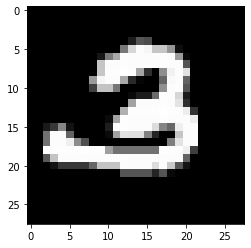

In [6]:
index = 63
img = data[0][index]
print(img.shape)
img = np.transpose(img, (1,2,0))
print(img.shape)
plt.imshow(img[:,:,0], cmap='gray')
label = data[1][index]
print(f'label: {label}')

In [7]:
class MLP_Model(nn.Module):
    def __init__(self):
        super(MLP_Model, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.flatten(x, 1) # [N,1,28,28] -> [N,728]로 변경시켜줌
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [8]:
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [9]:
# GPU 또는 CPU 사용을 위한 device 정의
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
model = MLP_Model().to(device)
# model = CNN_Model().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, data in enumerate(train_loader):
        images, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = F.nll_loss(outputs, labels)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{:5d}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(images), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [12]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            test_loss += F.nll_loss(outputs, labels, reduction='sum').item()  # sum up batch loss
            pred = outputs.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(labels.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [13]:
for epoch in range(10):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Train Epoch: 0 [    0/60000 (0%)]	Loss: 2.294574
Train Epoch: 0 [ 6400/60000 (11%)]	Loss: 0.390962
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.138746
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.170658
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.262617
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.134838
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.137086
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.105469
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.055566
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.193355

Test set: Average loss: 0.1383, Accuracy: 9593/10000 (96%)

Train Epoch: 1 [    0/60000 (0%)]	Loss: 0.095440
Train Epoch: 1 [ 6400/60000 (11%)]	Loss: 0.068852
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.126388
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.117814
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.074030
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.051980
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.040853
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.099497
Train Epoch: 1 [51200/60000 (85%)]	Loss: 